In [1]:
import matplotlib.pyplot as plt

In [2]:
import itertools

In [3]:
from egttools.analytical.utils import (calculate_gradients,
                                       find_roots,
                                       check_replicator_stability_pairwise_games)

In [4]:
import tqdm

In [5]:
def plot_nash(games, labels):

    fig, axes = plt.subplots(ncols=len(games), figsize=(4.5 * len(games), 1 * len(games)))
    
    for ax in axes:
    
        ax.set_ylabel("probability of playing $B$"); ax.set_xlabel("probability of playing $A$");
    
        ax.set_ylim(-0.1, 1.1); ax.set_xlim(-0.1, 1.1); 
        
    for i, (game, ax) in enumerate(zip(games, axes)):
    
        equilibria = game.support_enumeration()

        for eq in equilibria:
            x = eq[0][0]
            y = eq[1][0]

            ax.scatter(x, y, color='black', marker='^', s=100)
            ax.set_title(labels[i])
            
    plt.subplots_adjust(wspace=.4)

    return fig, axes

In [6]:
def plot_replicator(trajectories, labels):
    
    fig, ax = plt.subplots();
    
    ax.plot(trajectories, label=labels);
    
    for line, ls in zip(ax.get_lines(), itertools.cycle(['-', '--', ':', '.'])):
        line.set_linestyle(ls)
    
    ax.set_xlabel("timesteps")

    ax.set_ylabel("portotion of type in population")

    ax.legend();
    
    return fig, ax

In [7]:
def egttools_replicator_dynamics(game, label):
    
    x = np.linspace(0, 1, num=101, dtype=np.float64)
    
    matrix = game.payoff_matrices[0]
    
    fig, axes = plt.subplots(figsize=(5, 3.5))
    

    gradient_function = lambda x: egt.analytical.replicator_equation(x, matrix)
    gradients = calculate_gradients(np.array((x, 1 - x)).T, gradient_function)

    # Find roots and stability
    roots = find_roots(gradient_function, nb_strategies=2, nb_initial_random_points=10, method="hybr")
    stability = check_replicator_stability_pairwise_games(roots, matrix)

    egt.plotting.plot_gradients(gradients[:, 0],
                                xlabel=f"frequency of {label}",
                                roots=roots,
                                stability=stability,
                                ax=axes);


    return fig, axes

In [8]:
def plot_introspection_trajectory(result):
    x, y = zip(*result)
    
    fig, axes = plt.subplots(ncols=2, figsize=(10, 3.5))
    
    axes[0].plot(x, color='tab:red')
    axes[1].plot(y, color='tab:blue')
    
    axes[0].set_title("Row player actions")
    axes[1].set_title("Column player actions")
    
    for ax in axes:
        ax.set_ylabel("probability of playing A")
        ax.set_xlabel("timesteps")

In [9]:
def plot_introspection_states_distribution(result):
          
    dict_ = {(1, 1): '(D, D)', 
            (0, 0): '(C, C)', 
            (0, 1): '(C, D)',
            (1, 0): '(D, C)'}  
    
    result_transformed = [dict_[i] for i in result]
    
    fig, ax = plt.subplots();
    
    ax.bar(range(4),
        [result_transformed.count(state) / len(result) for state in ['(C, C)', '(C, D)', '(D, C)', '(D, D)']])

    ax.set_xticks(range(4), ['(C, C)', '(C, D)', '(D, C)', '(D, D)']);
    
    ax.set_ylabel("frequency")
    
    return fig, ax

In [10]:
def introspection_over_betas(game, initial_state, beta, max_timesteps):
    
    dict_ = {(1, 1): '(D, D)', 
            (0, 0): '(C, C)', 
            (0, 1): '(C, D)',
            (1, 0): '(D, C)'}    

    betas = [10 ** i for i in np.linspace(-2, 2, 20)]
    
    payoffs = game.payoff_matrices[0]

    states = []

    for beta in betas:

        result = introspection_dynamics(game, initial_state, beta, max_timesteps)
        result_transformed = [dict_[i] for i in result]

        states.append([result_transformed.count(state) / max_timesteps for state in 
                       list(dict_.values())])

    fig, ax = plt.subplots()
    
    ax.plot(states, label=list(dict_.values()))
    
    ax.set_xticks([0, 20], [0, 100])
    
    ax.set_xlabel("strenght of selection")
    
    ax.legend()
    
#     return fig, ax

In [11]:
def introspection_dynamics(game, initial_state, beta, max_timesteps):
    
    payoffs = game.payoff_matrices[0]
    strategies = initial_state
    states = [tuple(initial_state)]
    for timestep in range(max_timesteps):

        # select an individual to update strategy
        who_updates = np.random.choice([0, 1])
    
        current_strategy = strategies[who_updates]
        
        alternative_strategy = abs(1 - current_strategy)
        
        co_players_strategy = strategies[abs(who_updates - 1)]

        # the payoffs of the current strategy and the alternative
        current_payoff = payoffs[current_strategy][co_players_strategy]
    
        alternative_payoff = payoffs[alternative_strategy][co_players_strategy]

        # updating probability based on the fermi function
        update_probability = 1 / (np.e ** (-beta * (alternative_payoff - current_payoff)))
    
        if update_probability > np.random.random():
            
            strategies[who_updates] = alternative_strategy
    
        states.append(tuple(strategies))

    return states

## Nash Equilibria

In [12]:
import numpy as np

In [13]:
import nashpy as nash

In [14]:
payoffs_row_player = np.array([[4, 1], [3, 3]])
payoffs_col_player = np.array([[4, 3], [1, 3]])

stag_hunt = nash.Game(payoffs_row_player, payoffs_col_player)
stag_hunt

Bi matrix game with payoff matrices:

Row player:
[[4 1]
 [3 3]]

Column player:
[[4 3]
 [1 3]]

In [15]:
equilibria = stag_hunt.support_enumeration()

for eq in equilibria:
    print(eq)

(array([1., 0.]), array([1., 0.]))
(array([0., 1.]), array([0., 1.]))
(array([0.66666667, 0.33333333]), array([0.66666667, 0.33333333]))


In [16]:
payoffs_row_player = np.array([[2, 1], [3, 0]])
payoffs_col_player = np.array([[2, 3], [1, 0]])

chicken_game = nash.Game(payoffs_row_player, payoffs_col_player)
chicken_game

Bi matrix game with payoff matrices:

Row player:
[[2 1]
 [3 0]]

Column player:
[[2 3]
 [1 0]]

In [17]:
equilibria = chicken_game.support_enumeration()

for eq in equilibria:
    print(eq)

(array([1., 0.]), array([0., 1.]))
(array([0., 1.]), array([1., 0.]))
(array([0.5, 0.5]), array([0.5, 0.5]))


In [18]:
payoffs_row_player = np.array([[3, 0], [5, 1]])
payoffs_col_player = np.array([[3, 5], [0, 1]])

prisoners_dilemma = nash.Game(payoffs_row_player, payoffs_col_player)
prisoners_dilemma

Bi matrix game with payoff matrices:

Row player:
[[3 0]
 [5 1]]

Column player:
[[3 5]
 [0 1]]

In [19]:
equilibria = prisoners_dilemma.support_enumeration()

for eq in equilibria:
    print(eq)

(array([0., 1.]), array([0., 1.]))


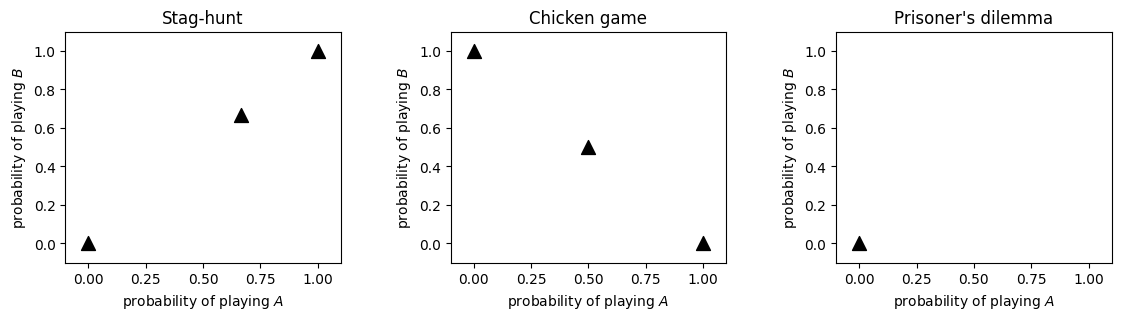

In [20]:
games = [stag_hunt, chicken_game, prisoners_dilemma]

labels = ['Stag-hunt', 'Chicken game', "Prisoner's dilemma"]

plot_nash(games, labels);

## Replicator dynamics

```python

def get_derivative_of_fitness(x, t, payoff_matrix):
    """
    Find the derivative of fitness function

    Parameters
    ----------
    x : array
        A population distribution.
    t : float
        A time point. This is not actually used but is needed in the function
        signature.
    payoff_matrix : array
        The payoff matrix

    Returns
    -------
    array
        The derivative of the population distribution.
    """
    fitness = payoff_matrix @ x
    mean_fitness = x.T @ payoff_matrix
    return fitness * x - x * mean_fitness

```

```python
def replicator_dynamics(payoff_matrix, y0=None, timepoints=None):
    """
    Implement replicator dynamics

    Parameters
    ----------
    payoff_matrix : array
        The payoff matrix
    y0 : array
        The initial population distribution.
    timepoints: array
        The iterable of timepoints.
    Returns
    -------
    array
        The population distributions over time.
    """

    if timepoints is None:
        timepoints = np.linspace(0, 10, 1000)

    if y0 is None:
        number_of_strategies = len(payoff_matrix)
        y0 = np.ones(number_of_strategies) / number_of_strategies

    xs = odeint(
        func=get_derivative_of_fitness, y0=y0, t=timepoints, args=(payoff_matrix)
    )
    return xs
```

In [21]:
payoffs_row_player = np.array([[3, 0], [5, 1]])
payoffs_col_player = np.array([[3, 5], [0, 1]])

prisoners_dilemma = nash.Game(payoffs_row_player, payoffs_col_player)
prisoners_dilemma

Bi matrix game with payoff matrices:

Row player:
[[3 0]
 [5 1]]

Column player:
[[3 5]
 [0 1]]

In [28]:
trajectories = stag_hunt.replicator_dynamics(y0=[0.5, 0.5])

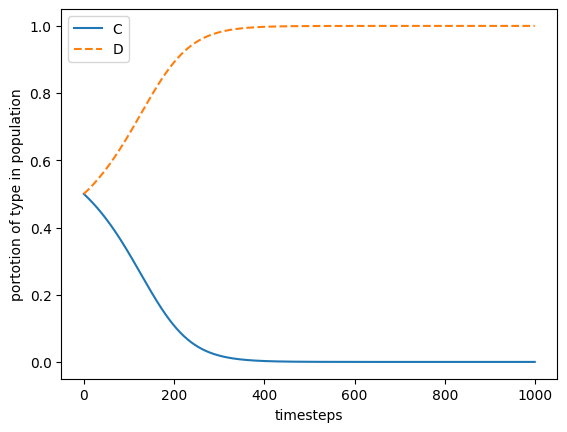

In [29]:
plot_replicator(trajectories, labels=['C',"D"]);

In [30]:
import egttools as egt

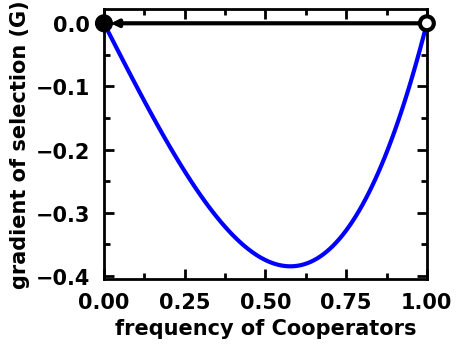

In [31]:
egttools_replicator_dynamics(prisoners_dilemma, "Cooperators");

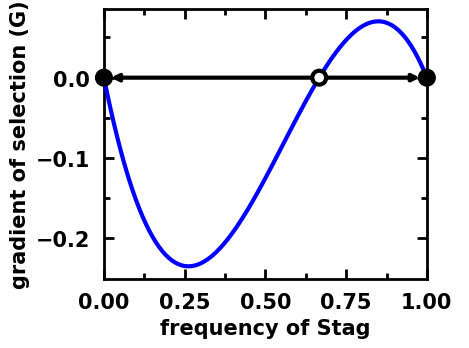

In [32]:
egttools_replicator_dynamics(stag_hunt, "Stag");

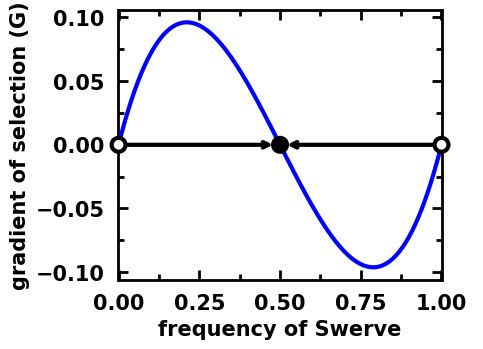

In [33]:
egttools_replicator_dynamics(chicken_game, "Swerve");

## Moran process

In [35]:
generations = prisoners_dilemma.moran_process(initial_population=[0, 0, 0, 1, 1])

for gen in generations:
    print(gen)

[1 0 0 1 1]
[1 0 0 1 1]
[1 0 0 0 1]
[1 0 0 0 1]
[1 0 1 0 1]
[1 1 1 0 1]
[1 1 1 0 1]
[1 1 1 0 1]
[1 1 1 0 1]
[1 1 1 0 1]
[1 1 1 0 1]
[1 1 1 0 1]
[1 1 1 1 1]


In [36]:
game = prisoners_dilemma

In [37]:
N = 10

fixation_numerical = []

for i in tqdm.tqdm(range(1, N)):
    fixation_for_initial = 0
    
    k = N - i
    initial_population = [0 for _ in range(i)] + [1 for _ in range(k)]

    for num_of_simulations in range(10 ** 3):
        np.random.seed(num_of_simulations)
        generations = game.moran_process(initial_population=initial_population)

        last_population = tuple(generations)[-1]
    
        if 1 in last_population:
            fixation_for_initial += 1

    fixation_numerical.append(fixation_for_initial)

100%|█████████████████████████████████████████████| 9/9 [00:24<00:00,  2.69s/it]


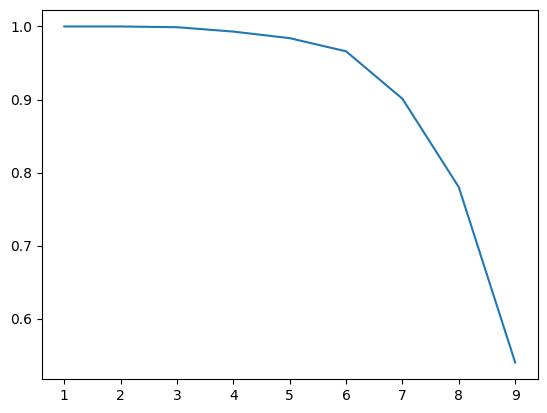

In [42]:
plt.plot(range(1, 10), np.array(fixation_numerical) / 10 ** 3)

### Introspection dynamics

```python
def introspection_dynamics(game, initial_state, beta, max_timesteps):
    
    payoffs = game.payoff_matrices[0]
    strategies = initial_state
    states = [tuple(initial_state)]
    for timestep in range(max_timesteps):

        # select an individual to update strategy
        who_updates = np.random.choice([0, 1])
    
        current_strategy = strategies[who_updates]
        
        alternative_strategy = abs(1 - current_strategy)
        
        co_players_strategy = strategies[abs(who_updates - 1)]

        # the payoffs of the current strategy and the alternative
        current_payoff = payoffs[current_strategy][co_players_strategy]
    
        alternative_payoff = payoffs[alternative_strategy][co_players_strategy]

        # updating probability based on the fermi function
        update_probability = 1 / (np.e ** (-beta * (alternative_payoff - current_payoff)))
    
        if update_probability > np.random.random():
            
            strategies[who_updates] = alternative_strategy
    
        states.append(tuple(strategies))

    return states
```

In [59]:
max_timesteps = 10 ** 3

beta = 5

initial_state = [0, 0]

In [60]:
result = introspection_dynamics(stag_hunt, initial_state, beta, max_timesteps)

In [61]:
result[:5]

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]

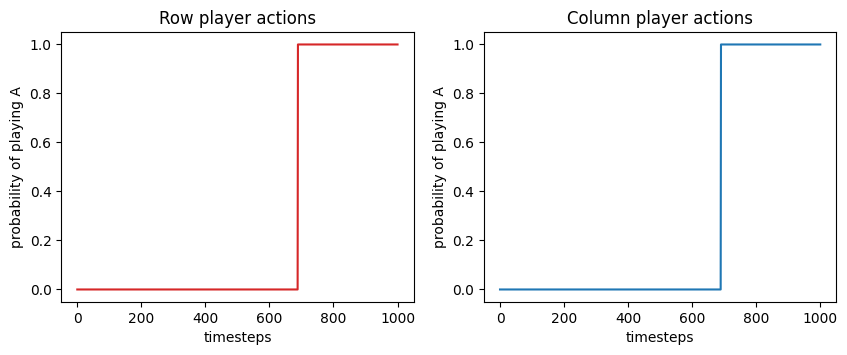

In [62]:
plot_introspection_trajectory(result)

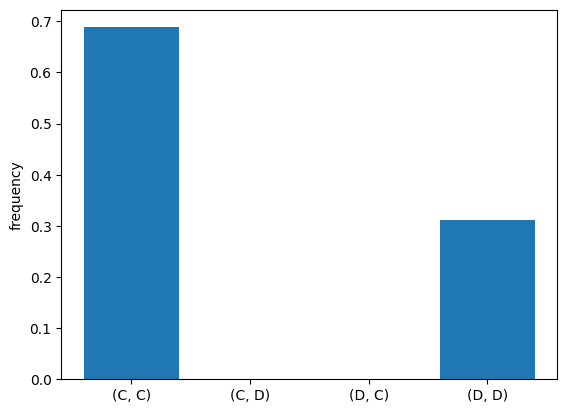

In [63]:
plot_introspection_states_distribution(result);

In [ ]:
max_timesteps = 10 ** 3

beta = 5

initial_state = [0, 0]



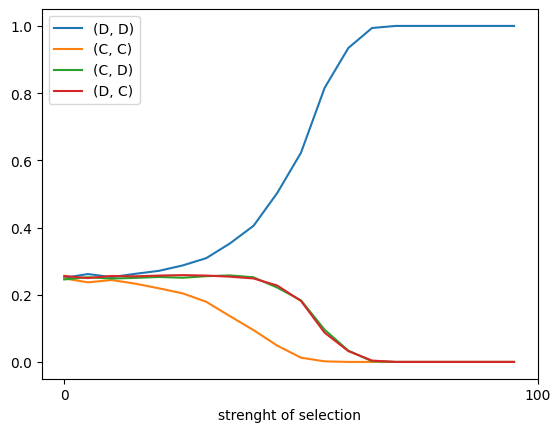

In [65]:
max_timesteps = 10 ** 4

introspection_over_betas(prisoners_dilemma, [0, 0], beta, max_timesteps);